In [1]:
import numpy as np
import fitsio
import healpy as hp
import matplotlib.pyplot as plt

# _IMPORTANT NOTE ABOUT NAMING_

The word "Star" is often used in variable names here even if stars aren't necessarily being used. This is because I was writing with the final application in mind which will be applying this software to stars specifically.

### Columns are Called 'PIXEL' and 'SIGNAL'

In [55]:
# This reads in the data for whichever condition we want to generate a plot for.
condFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/airmass/y3a2_z_o.4096_t.32768_AIRMASS.WMEAN_EQU.fits.gz'
condMap = hp.fitsfunc.read_map(condFile, nest = True)
condMap[condMap==-1.6375e+30]=hp.UNSEEN
condSigExt=hp.ud_grade(condMap,2048) # Stands for condition signal extended to whole map (not just valid pixels).

In [3]:
# This reads in the data for what fraction of each pixel was actually observed.
fracFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/fracdet/y3a2_i_o.4096_t.32768_frac_EQU.fits.gz'
fracMap = hp.fitsfunc.read_map(fracFile, nest = True)
fracMap[fracMap==-1.6375e+30]=hp.UNSEEN
fracDetExt = hp.ud_grade(fracMap,2048) # Stands for fraction detected extended to whole map (not just valid pixels).

In [4]:
# matchedFile = '/hdfs/bechtol/balrog/y3/balrog_matched_catalog_sof_y3-merged_v1.2.fits'
# '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
starFile = '/hdfs/bechtol/balrog/y3/balrog_detection_catalog_sof_y3-merged_v1.2.fits'

### Remove Extended Class When Switching to Stars

In [5]:
# This reads in all of the data. Most of these are just flags, the only pieces that get used much outside
# of filtering are true_ra and true_dec which get used to convert into healPixels.
starData = fitsio.read(starFile, columns = ['detected', 'true_ra', 'true_dec', 'meas_EXTENDED_CLASS_SOF',
                                            'flags_foreground', 'flags_badregions', 'flags_footprint',
                                            'meas_FLAGS_GOLD_SOF_ONLY', 'match_flag_1.5_asec'])

In [6]:
# These are in degrees which is why lonlat is set to True in the next cell.
RA = starData['true_ra']
DEC = starData['true_dec']
# Everything from here on out is simply used in order to filter the data
DETECTED = starData['detected'] # This specifically is used for now to filter out any non detected injection.
FOREGROUND = starData['flags_foreground']
BADREGIONS = starData['flags_badregions']
FOOTPRINT = starData['flags_footprint']
GOLDSOF = starData['meas_FLAGS_GOLD_SOF_ONLY']
ARCSECONDS = starData['match_flag_1.5_asec']
CLASS = starData['meas_EXTENDED_CLASS_SOF']
# i_mag = starData['meas_cm_mag_deredden'][:,2] This gets used if we filter at all based on i magnitude.

# This is used to filter out any injections that either weren't detected or had flags raised.
cutIndices = np.where((DETECTED == 1) &
                      (FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      (GOLDSOF < 2) & 
                      (CLASS >= 0) &
                      (ARCSECONDS < 2))[0]

RA = RA[cutIndices]
DEC = DEC[cutIndices]

In [7]:
# This converts the RA and DEC values from above to healpixels so we can compare to the sky condition.
starPixels = hp.ang2pix(2048, RA, DEC, lonlat = True, nest = True)

In [56]:
# Here I consider a valid pixel any pixel that has a non "bad value" for the condition and fracDet 
# and that has at least one of the filtered stars in it.
validPixels1 = np.full(12*(2048**2), False, dtype = bool)
validPixels2 = np.full(12*(2048**2), False, dtype = bool)
validPixels3 = np.full(12*(2048**2), False, dtype = bool)
validPixels1[np.where(condSigExt >= 0)[0]] = True
validPixels2[np.where(fracDetExt >= 0)[0]] = True
validPixels3[starPixels] = True

validPixels = validPixels1 & validPixels2 & validPixels3

In [57]:
# This gets the indices of the stars that are at valid pixels (this shouldn't filter out many at all).
starIndices = np.where(validPixels[starPixels])[0]

In [58]:
# This generates the condition values and fraction detected at the valid pixels.
condSig = condSigExt[validPixels]
fracDet = fracDetExt[validPixels]

# This tells me which pixels correspond to the values above.
condPix = np.where(validPixels)[0]

# This tells me the pixels for the stars, it will be the same as condPix but have repeats if multiple stars are detected
# on one pixel. By default these will not be sorted.
starPix = starPixels[starIndices]

# This sorts the pixels. This may seem like an unnecessarily difficult way to do it but it could be useful for future projects
# and it doesn't take much more space or time so I chose to leave it in.
sortInds = starPix.argsort()
starPix = starPix[sortInds[::1]]

#### General Algorithm Now

Every time there's a pixel repeat, smush the indices together (so like if the starPix was [1, 2, 2, 3, 4] then I want to generate the array [1, 2, 1, 1]).

In [59]:
# These are indices that will be looping through the condPix and starPix arrays in parallel.
condInd = 0
starInd = 0

# This will be used to store the number of stars at each pixel.
balStar = np.zeros_like(condPix)

while starInd < len(starPix):
    if condPix[condInd] == starPix[starInd]: # If the pixels match up in the arrays.
        balStar[condInd] += 1                # Add one to the corresponding spot in the balStar array.
        starInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
        # Since the last index of condPix and starPix are the same, starInd will increase the last time through the loop,
        # making this the index that we must restrict in the while loop.
    else:
        condInd += 1 # If the pixels are no longer the same, increase the index you check in the condPix array.

In [60]:
# This gets the average number of detections per one full pixel.
aveDens = len(starPix) / np.sum(fracDet)

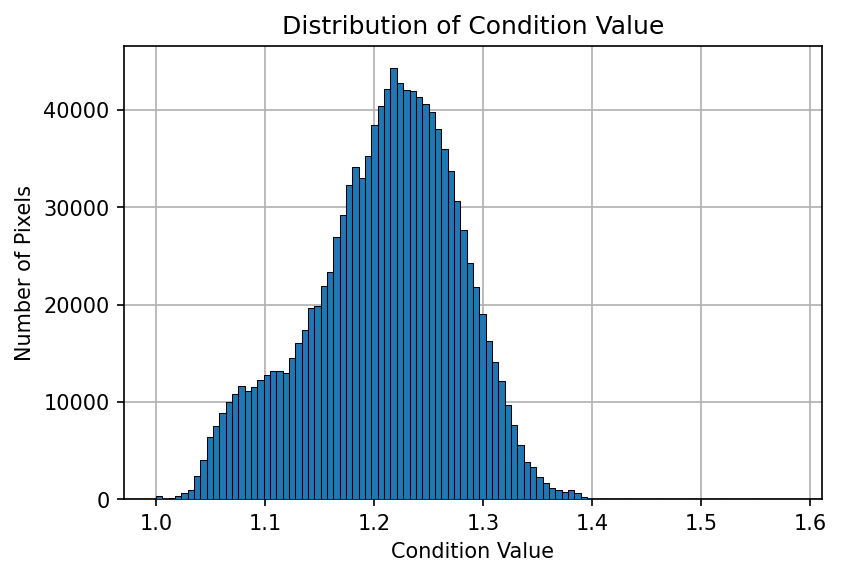

In [61]:
# This generates a plot of the distribution of the condition, which is useful for seeing what bin size to use.
plt.figure(dpi = 150)
plt.grid(zorder = 0)
plt.hist(condSig, bins = 100, edgecolor='black', linewidth=.5, zorder = 3)
plt.xlabel('Condition Value')
plt.ylabel('Number of Pixels')
plt.title('Distribution of Condition Value')
#plt.yscale('log')
plt.show()

#### Changeable Parameters

In [62]:
# These set the lower and upper limits on the bins as well as the number of bins.
condMin = 1
condMax = 1.4
numBins = 25

In [63]:
# This generates the x values to be used in the final plot as the middle value of each bin.
xValues = np.linspace(condMin, condMax, numBins, endpoint = False) + (condMax - condMin) / (2 * numBins)

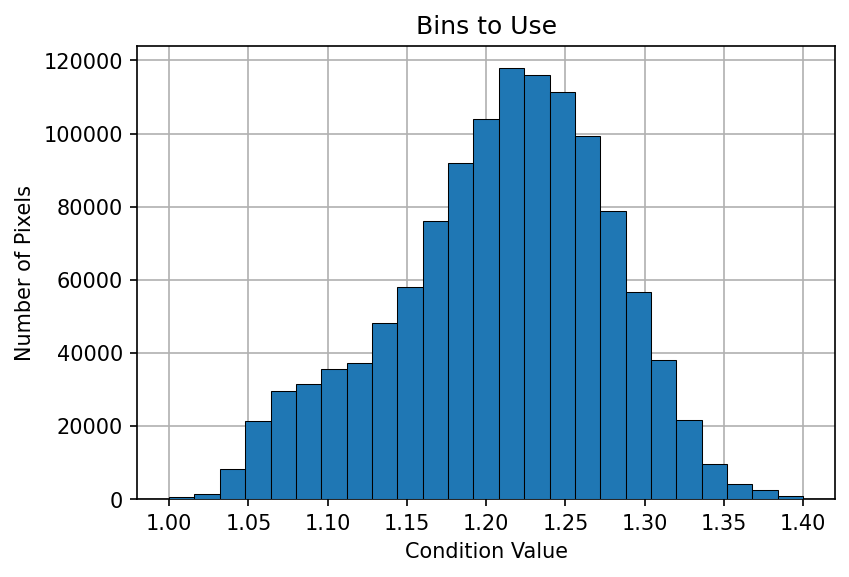

In [72]:
# This shows what the bins will actually look like, which can be useful in seeing if any of the bins are too small.
plt.figure(dpi = 150)
plt.grid(zorder = 0)
plt.hist(condSig, bins = np.linspace(condMin, condMax, numBins + 1), edgecolor='black', linewidth=.5, zorder = 3)
# plt.yscale('log')
plt.title('Bins to Use')
plt.xlabel('Condition Value')
plt.ylabel('Number of Pixels')
plt.show()

In [65]:
def binIndicesByCondition(cond, condMin, condMax, numBins): # This bins together the indices.
    binBounds = np.linspace(condMin, condMax, (numBins + 1), endpoint = True)
    indByBin = []
    for i in range(len(binBounds) - 1):
        validIndices = np.array(np.where((cond >= binBounds[i]) & (cond <= binBounds[i + 1]))[0])
        # I used both >= and <= even though this could result in repeats since what we're after is the "detection efficiency"
        # in a certain range of conditions and I didn't think repeats would really matter. Easy switch if desired though.
        indByBin.append(validIndices)
    return np.array(indByBin, dtype = object)

In [66]:
# This generates the indices for each bin.
binInd = binIndicesByCondition(condSig, condMin, condMax, numBins)

In [67]:
percentBins = []

for i in range(len(binInd)):
    totalBal = np.sum(balStar[binInd[i]]) # Total number of detections within the bin.
    percentBins.append(totalBal / np.sum(fracDet[binInd[i]])) # Total effective area within the bin.

relPerBins = np.array(percentBins) / aveDens # This normalizes the data, relative percent bins.

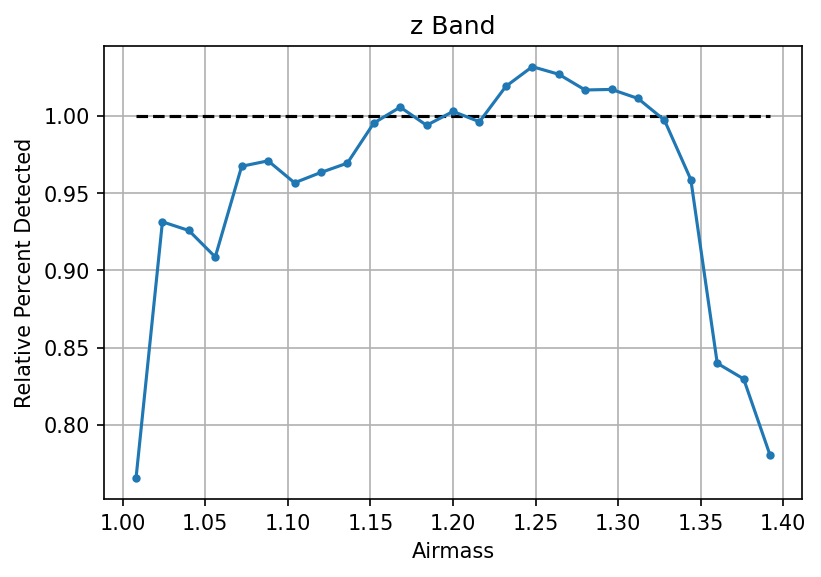

In [68]:
# This is the final plot.
plt.figure(dpi = 150)
plt.plot(xValues, relPerBins, marker = '.', zorder = 3)
plt.plot(xValues, np.ones_like(xValues), color = 'k', linestyle = '--')
# plt.ylim([0.6, 1.3])
plt.title('z Band')
plt.ylabel('Relative Percent Detected')
plt.xlabel('Airmass')
plt.grid()
plt.show()

The commented code below shows some patterns in the fracDet property.

In [69]:
# plt.figure(dpi = 150)
# plt.hist(healMap, bins = np.linspace(0, 1, 65))
# highPeaks = 0
# for i in np.arange(1, 8):
#     highPeaks += i
#     plt.axvline(x = (highPeaks/64) +1/128, color = 'black', linestyle = '--')
#     plt.axvline(x = 1-(highPeaks/64) +1/128, color = 'black', linestyle = '--')
# plt.yscale('log')
# plt.xlabel('FracDet')
# plt.ylabel('Counts')
# plt.title('Patterns in FracDet')
# plt.show()

In [70]:
list(relPerBins)

[0.7654044906640206,
 0.9314777320227904,
 0.9258665650292299,
 0.9087278319840975,
 0.967421611470717,
 0.9709410596817777,
 0.9567270028038651,
 0.9634293262004183,
 0.9694433671263448,
 0.9953651453347562,
 1.0056738066127957,
 0.9939316184860227,
 1.0028990415309358,
 0.9962133582015185,
 1.0191311668089376,
 1.0318620160227439,
 1.0269605648830598,
 1.016782382176582,
 1.0171391113391641,
 1.0112971400850017,
 0.9972956066891396,
 0.9588116864724742,
 0.8399642239907871,
 0.8298275383626621,
 0.7804318452032245]